In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob
import matplotlib
sns.set_palette('colorblind',10)
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('axes',labelsize=20) 
from astropy.table import Table
import os
__outdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/Output/'
__datdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/data/KepxDR2/'

In [2]:
def read_data():
    '''Reads in the Yu et al. 2018 data'''
    sfile = __datdir__+'rcxyu18.csv'
    df = pd.read_csv(sfile)
    return df

def read_paramdict(majorlabel, minorlabel='', sort='astero'):
    '''Reads in results for either:
        -A full run series (majorlabel) where the minorlabel is included as a
            column in the output.
        -A single run (majorlabel and minorlabel).

        Returns a pandas dataframe.
    '''
    loc = __outdir__+majorlabel+'/'

    if minorlabel != '':
        globlist = glob.glob(loc+sort+'_'+str(float(minorlabel))+'_*pars*.csv')
    else:
        globlist = glob.glob(loc+sort+'*_*pars*.csv')

    minorlabels = [os.path.basename(globloc).split('_')[1] for globloc in globlist]
    if sort == 'gaia':
        ccdlabels = [os.path.basename(globloc).split('_')[-2] for globloc in globlist]
        
    df = pd.DataFrame()
    for n, globloc in enumerate(globlist):
        sdf = pd.read_csv(globloc, index_col = 0)
        if minorlabels[n] != 'pars.csv':
            sdf[majorlabel] = minorlabels[n]
            sdf['ccdlabel'] = ccdlabels[n]
        df = df.append(sdf)

    return df.sort_values(by=majorlabel)

In [3]:
df = read_data()

In [4]:
for i in range(len(np.unique(df.ccd.values))):
    print('CCD #'+str(i)+' : '+str(len(df[df.ccd == i])))

CCD #0 : 185
CCD #1 : 156
CCD #2 : 124
CCD #3 : 325
CCD #4 : 261
CCD #5 : 226
CCD #6 : 201
CCD #7 : 139
CCD #8 : 394
CCD #9 : 352
CCD #10 : 254
CCD #11 : 284
CCD #12 : 137
CCD #13 : 71
CCD #14 : 278
CCD #15 : 513
CCD #16 : 386
CCD #17 : 188
CCD #18 : 167
CCD #19 : 489
CCD #20 : 448


In [7]:
gr = read_paramdict('test_build/gaia_nodiff_ccdtest','0.','gaia')
gr

,sigo_std,Q,mu_std,oo_zp,L,sigo,mu,Q_std,L_std,oo_zp_std,sigma,sigma_std,test_build/gaia_nodiff_ccdtest,ccdlabel
0,0.614752,0.916916,0.005307,-27.897266,893.479106,4.873704,-1.712043,0.039884,32.900341,16.458314,0.155158,0.019637,0.0,10
0,0.803032,0.872839,0.005330,-28.222513,788.474978,2.548753,-1.710871,0.125615,41.667535,16.371900,0.140773,0.026987,0.0,2
0,0.605710,0.820029,0.005319,-29.297921,878.296646,2.944663,-1.707858,0.104869,30.703405,15.947457,0.098654,0.019056,0.0,11
0,0.844531,0.690335,0.005172,-29.628048,792.607223,3.495196,-1.711000,0.103587,38.663651,16.618718,0.066287,0.022056,0.0,7
0,0.720484,0.776386,0.005406,-27.626692,759.468215,2.940471,-1.710347,0.119576,35.733066,16.337417,0.100602,0.025519,0.0,1
0,0.568412,0.828048,0.005252,-31.849510,946.990839,3.596411,-1.709615,0.073336,28.188767,16.310193,0.099263,0.016380,0.0,16
0,0.644459,0.880318,0.005266,-33.638465,921.804097,4.954109,-1.708591,0.039573,28.479967,16.298090,0.076400,0.010518,0.0,9
0,0.697978,0.715930,0.005307,-32.797487,928.501293,2.614759,-1.711478,0.131729,30.746550,16.251270,0.099867,0.027169,0.0,3
0,0.633397,0.809195,0.005334,-33.754955,875.316245,3.710360,-1.710650,0.080530,31.849407,16.184423,0.096552,0.018841,0.0,4
0,0.633495,0.967433,0.005388,-30.201520,818.820435,6.445889,-1.711607,0.017585,35.270727,16.131327,0.169959,0.013714,0.0,0


In [8]:
gr.ccdlabel.astype(int).values

array([10,  2, 11,  7,  1, 16,  9,  3,  4,  0, 14,  8, 13, 12,  5,  6, 15])

In [9]:
df['oo_zp'] = np.ones(len(df))
df['L'] = np.ones(len(df))
for ccd in gr.ccdlabel.astype(int).values:
    df['oo_zp'][df.ccd == ccd] *= gr[gr.ccdlabel == str(ccd)].oo_zp.values[0]
    df['L'][df.ccd == ccd] *= gr[gr.ccdlabel == str(ccd)].L.values[0]
df[df.L == 1.] = np.nan
df[df.oo_zp == 1.] = np.nan

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


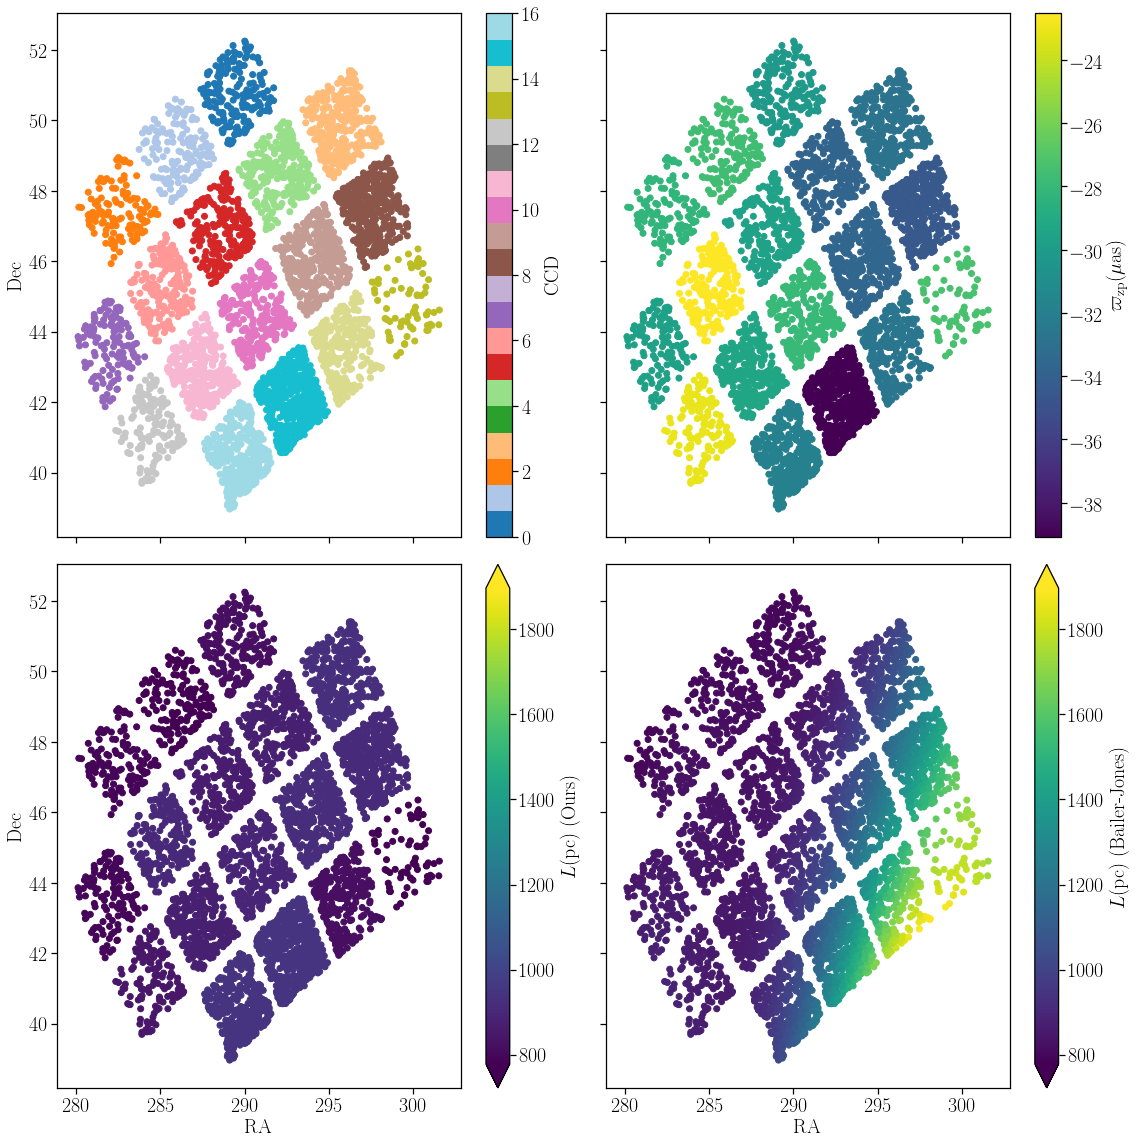

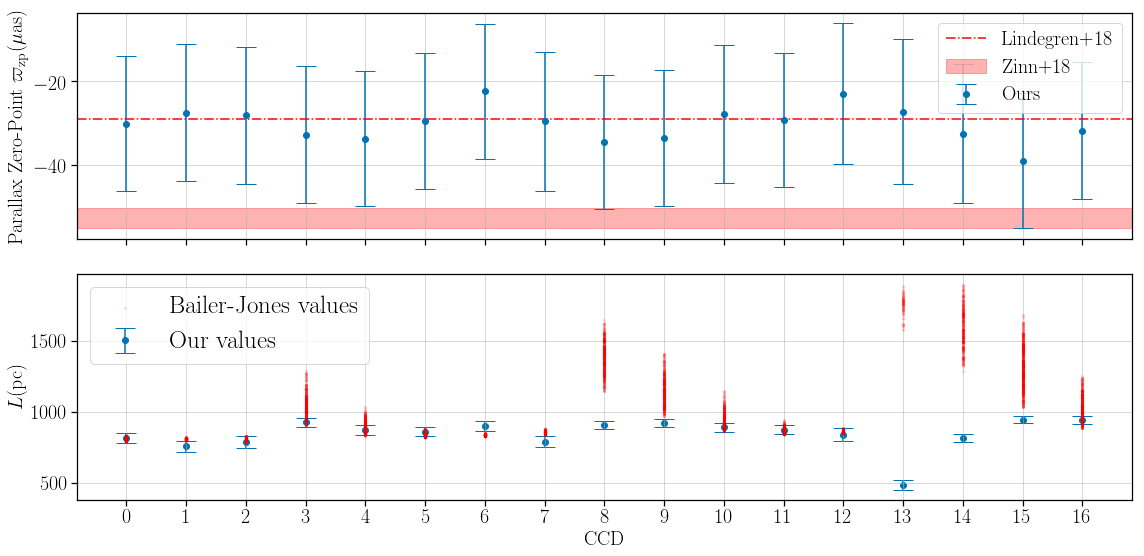

In [38]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16,16),sharex=True, sharey=True)
c1 = ax1.scatter(df.ra, df.dec, c = df.ccd, cmap='tab20')
c2 = ax2.scatter(df.ra, df.dec, c = df.oo_zp, cmap='viridis')
c3 = ax3.scatter(df.ra, df.dec, c = df.L, vmin=df.r_length_prior.min(), vmax = df.r_length_prior.max())
c4 = ax4.scatter(df.ra, df.dec, c = df.r_length_prior,vmin=df.r_length_prior.min(), vmax = df.r_length_prior.max())

fig.colorbar(c1,ax=ax1,label='CCD')
fig.colorbar(c2, ax=ax2, label=r'$\varpi_{\rm zp} (\mu \rm as)$')
fig.colorbar(c3, ax=ax3, label=r'$L (\rm pc)$ (Ours)', extend='both')
fig.colorbar(c4, ax=ax4, label=r'$L (\rm pc)$ (Bailer-Jones)', extend='both')

ax3.set_xlabel('RA')
ax4.set_xlabel('RA')
ax1.set_ylabel('Dec')
ax3.set_ylabel('Dec')
plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,8), sharex=True)
(_, caps1,_) = ax1.errorbar(gr.ccdlabel.astype(int).values, gr.oo_zp, yerr=gr.oo_zp_std, fmt='o', capsize=10, label='Ours')
ax1.axhline(-29., c='r', linestyle='-.', label='Lindegren+18')
ax1.axhspan(-52.8-2.4, -52.8+2.4, alpha=.3, color='r', label='Zinn+18')
ax1.legend(fontsize=20)


(_, caps2,_) = ax2.errorbar(gr.ccdlabel.astype(int).values, gr.L, yerr=gr.L_std, fmt='o', capsize=10, label='Our values', zorder=1)
for cap1, cap2 in zip(caps1, caps2):
    cap1.set_markeredgewidth(1)
    cap2.set_markeredgewidth(1)
ax2.scatter(df.ccd.values, df.r_length_prior, s=5,c='r', alpha=.1, label='Bailer-Jones values', zorder=2)

ax2.set_xticks(gr.ccdlabel.astype(int).values)
ax2.set_xlabel(r'CCD #')
ax1.set_ylabel(r'Parallax Zero-Point $\varpi_{\rm zp} (\mu \rm as)$')
ax2.set_ylabel(r'$L (\rm pc)$')
ax2.legend(fontsize=25)

ax1.grid(alpha=.5)
ax2.grid(alpha=.5)
plt.tight_layout()
plt.show()

# Conclusions

Some of this I'm not sure about. For starters there are some clear outliers, such as CCD 13. Then the gradient of L exists as expected but is not in the same direction as we expect from the Bailer-Jones work. Whats more, our own brief study of TRILEGAL simulations of the Kepler field indicate that Bailer-Jones **underestimates** the length scale L by including MS and Sub-giant stars in their sample, so really our values should be larger, now smaller.

Maybe theres still an issue with the model? It would be interesting to rerun on a ccd-by-ccd basis but without accounting for covariance.

**Another explanation** of course would be that the position of the clump varies throughout the field, and that the zero-point is adjusting for this.

In [5]:
e = .5

s = np.sqrt(e**2+e**2+e**2+e**2+e**2)
print(s)
print(e/np.sqrt(5))

1.118033988749895
0.22360679774997896
